<a href="https://colab.research.google.com/github/SophistryDude/DS-Unit-2-Applied-Modeling/blob/master/module1-define-ml-problems/NIck_M's_Copy_of_231_guided_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---



# Define ML problems
- Choose a target to predict, and check its distribution
- Avoid leakage of information from test to train or from target to features
- Choose an appropriate evaluation metric


### A note in preparation for Unit 3

When you're doing your initial data exploration, you're educating yourself about the data, assessing data integrity, and formulating a plan of attack for your predictive model.

The best answer to any of these questions may vary from dataset to dataset. *Experiment* with a simple model to help you through the exploratory data analysis phase.

#### Meaningful Variation
  - Are there any features that are simply constant or quasi-constant values? 
  - Duplicated features?
  - Duplicated rows?
  - Are any of your features highly correlated together?
    - Linear models can be particularly sensitive to multi-collinearity.
    - Larger (esp. wide) datasets tend to have redundant features.

#### Categorical Encodings

  - What are your high cardinality categories?
  - Are there any rare labels that might benefit from grouping together?
  - Are there any categories that could be transformed into a meaningful rank (custom ordinal encoding)?

#### Distributions

  - What are the frequencies of your categorical labels?
  - Is your target feature normally distributed? (Assumption for linear regression model)

#### Outliers
  - How sensitive is your model type to outliers?
    - Less sensitive models include tree-based models. 
    - Linear models, neural networks, and other distance-based models will almost always benefit from scaling.
  - What strategy will you use to identify and handle outliers?

#### Feature Selection

  Why should we reduce the number of features?
  - Reduces potential overfitting
  - Fewer features -> easier interpretation for your stakeholders.
  - Easier implementation and maintain by software engineers.
  - Reduced computational resource requirement.

#### Reproducibility

  - Always set a random seed.
  - Comment, comment, comment!
  - Print out versions of your software.
  - Implement version control for your *data* as well as your *code* (esp. with timestamps!)
  - Wrap your code in reproducible functions / classes for modularity of steps, including feature loading, data wrangling, feature processing, etc. (i.e., *use sklearn pipelines!*)
  - Combine your modularized functions / classes in a single, centralized pipeline to execute your modularized 
  - Print out / record your final model parameters (optimized hyperparameter values).
  - Record other details of the model: final features passed in, transformations employed, etc.(Jupyter makes this very transparent, but long notebooks can be more confusing than long-form scripts. 


### Setup


In [149]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Choose a target to predict, and check its distribution

## Overview

This is the data science process at a high level:

<img src="https://image.slidesharecdn.com/becomingadatascientistadvice-pydatadc-shared-161012184823/95/becoming-a-data-scientist-advice-from-my-podcast-guests-55-638.jpg?cb=1476298295">

—Renee Teate, [Becoming a Data Scientist, PyData DC 2016 Talk](https://www.becomingadatascientist.com/2016/10/11/pydata-dc-2016-talk/)

We've focused on the 2nd arrow in the diagram, by training predictive models. Now let's zoom out and focus on the 1st arrow: defining problems, by translating business questions into code/data questions.

Last sprint, you did a Kaggle Challenge. It’s a great way to practice model validation and other technical skills. But that's just part of the modeling process. [Kaggle gets critiqued](https://speakerdeck.com/szilard/machine-learning-software-in-practice-quo-vadis-invited-talk-kdd-conference-applied-data-science-track-august-2017-halifax-canada?slide=119) because some things are done for you: Like [**defining the problem!**](https://www.linkedin.com/pulse/data-science-taught-universities-here-why-maciej-wasiak/) In today’s module, you’ll begin to practice this objective, with your dataset you’ve chosen for your personal portfolio project.

When defining a supervised machine learning problem, one of the first steps is choosing a target to predict.

Which column in your tabular dataset will you predict?

Is your problem regression or classification? You have options. Sometimes it’s not straightforward, as we'll see below.

- Discrete, ordinal, low cardinality target: Can be regression or multi-class classification.
- (In)equality comparison: Converts regression or multi-class classification to binary classification.
- Predicted probability: Seems to [blur](https://brohrer.github.io/five_questions_data_science_answers.html) the line between classification and regression.

## Follow Along

Let's reuse the [Burrito reviews dataset.](https://nbviewer.jupyter.org/github/LambdaSchool/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb) 🌯


In [150]:
import pandas as pd
pd.options.display.max_columns = None
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv',
                 parse_dates=['Date'],
                 index_col='Date')

### Choose your target 

Which column in your tabular dataset will you predict?


In [151]:
df.head()

,Location,Burrito,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,Donato's taco shop,California,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-24,Oscar's Mexican food,California,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-24,Oscar's Mexican food,Carnitas,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-24,Oscar's Mexican food,Carne asada,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-27,Pollos Maria,California,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
df['overall'].unique()

array([3.8    , 3.     , 3.75   , 4.2    , 3.2    , 2.6    , 3.9    ,
       2.     , 2.5    , 2.75   , 4.1    , 4.     , 3.5    , 4.6    ,
       4.5    , 4.25   , 3.4    , 1.     , 3.33333, 3.25   , 4.3    ,
       3.3    , 3.6    , 2.8    , 4.4    , 4.7    , 5.     , 1.5    ,
       1.8    , 4.9    , 3.7    , 2.9    , 4.8    , 2.7    , 2.3    ,
           nan, 2.2    , 2.4    , 3.1    , 2.66   ])

# EDA




In [153]:
df['overall'].describe()

count    421.000000
mean       3.620887
std        0.755718
min        1.000000
25%        3.100000
50%        3.800000
75%        4.100000
max        5.000000
Name: overall, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


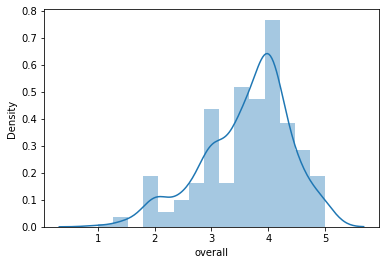

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df['overall']);


#Establishing a baseline


# Avoid leakage of information from test to train or from target to features

## Overview

Overfitting is our enemy in applied machine learning, and leakage is often the cause.

> Make sure your training features do not contain data from the “future” (aka time traveling). While this might be easy and obvious in some cases, it can get tricky. … If your test metric becomes really good all of the sudden, ask yourself what you might be doing wrong. Chances are you are time travelling or overfitting in some way. — [Xavier Amatriain](https://www.quora.com/What-are-some-best-practices-for-training-machine-learning-models/answer/Xavier-Amatriain)

Choose train, validate, and test sets. Are some observations outliers? Will you exclude them? Will you do a random split or a time-based split? You can (re)read [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/).

## Follow Along

First, begin to **explore and clean your data.**

In [155]:
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [156]:
df['Burrito'].nunique()

132

In [157]:
# What kinds of burritos?
df['Burrito'].unique()

array(['California ', 'Carnitas', 'Carne asada', 'California',
       'combo chicken', 'Monster California', 'Carne Asada',
       'Surf & Turf', 'Chile verde pork', 'battered fish ',
       'Surf and turf ', 'Adobada ', 'Barbacoa', '2 in 1', 'Adobado',
       'Shredded beef', 'Hawaiian', 'Bandido', 'Campeon', 'carne asada',
       'California chicken', 'Azteca', 'Lobster', 'Al pastor', 'Custom',
       'Machaca', 'Quesaburro', 'Philly ', 'Quesa', 'Surf and turf',
       'Mahi', 'Addiction', 'Oaxacalifornia', "Deborah's special",
       'Chicken nopalito', 'Adobada', 'Chicken', 'California Everything',
       'Chile relleno and carnitas', 'California (only cheese)', 'Fish',
       'Chimichanga beef', 'Pastor', 'El Hawaiiano ', 'Shrimp',
       'El Rusio', 'Bacon breakfast', 'Chile Relleno', 'Bomb', 'Arizona',
       'California Burrito', '619 Burrito Original', 'Chicken asada',
       'Carne adobada ', 'Bean and cheese', 'Pokirrito classic ',
       'Mauna Lani', 'Especial ', 'Ranchero

In [158]:
# Combine Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])
df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

df['Burrito'].value_counts()

California     170
Other          156
Asada           43
Surf & Turf     29
Carnitas        25
Name: Burrito, dtype: int64

In [159]:
df.isna().sum().sort_values()

Burrito             0
Date                0
Tortilla            0
Synergy             2
Uniformity          2
overall             2
Hunger              3
Wrap                3
Fillings            3
Cost                7
Meat:filling        9
Meat               14
Temp               20
Salsa              25
Length            139
Volume            141
Circum            141
Rec               190
Beef              243
Cheese            263
Pico              264
Guac              268
Fries             295
Sour cream        331
Google            336
Yelp              336
Pork              372
Sauce             385
Rice              387
Beans             388
Unreliable        390
Chips             397
Mass (g)          401
Density (g/mL)    401
Chicken           402
Shrimp            402
Onion             406
Cilantro          408
Avocado           410
Lettuce           412
Cabbage           415
Bell peper        416
Tomato            416
Salsa.1           416
NonSD             416
Pineapple 

Next, do a **time-based split:**

- Train on reviews from 2016 & earlier. 
- Validate on 2017. 
- Test on 2018 & later.

In [160]:
df['Date'] = pd.to_datetime(df['Date'])

### How is your target distributed?

For a classification problem, determine: How many classes? Are the classes imbalanced?

In [161]:
df['great'] = (df['overall'] > 4).astype(int)
df.drop(columns=['overall', 'Rec'], inplace=True)
ohe_cats = df.select_dtypes('object').nunique()
ohe_cols = [col for col in ohe_cats.index if ohe_cats[col] <= 2]
for col in ohe_cols:
  df[col] = df[col].str.lower().apply(lambda x: 1 if x=='x' else 0)
thresh = 10
unique_cats = df.select_dtypes('object').nunique()
high_card_cols = [col for col in unique_cats.index if unique_cats[col] > thresh]
df = df.drop(high_card_cols, axis=1)
df = df.dropna(axis=1, thresh=400)


In [162]:
df = df.fillna('Missing')

In [163]:
train = df[df['Date'].dt.year < 2017]
val = df[df['Date'].dt.year == 2017]
test = df[df['Date'].dt.year > 2018]

In [164]:
train.shape, val.shape, test.shape

((300, 49), (85, 49), (11, 49))

In [165]:
target = 'great'
y = df[target]
X = df.drop(target, axis=1)
print('Number of classes:', y.nunique())

Number of classes: 2


In [166]:
y.value_counts(normalize=True)

0    0.744681
1    0.255319
Name: great, dtype: float64

In [167]:
df.head()

,Burrito,Date,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,great
0,California,2016-01-18,6.49,3,3.0,5,3,3.5,4,4,4,4,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,California,2016-01-24,5.45,3.5,2.0,3.5,2.5,2.5,2,4,2.5,5,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Carnitas,2016-01-24,4.85,1.5,3.0,2,2.5,3,4.5,4,3,5,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Asada,2016-01-24,5.25,2,3.0,2,3.5,3,4,5,4,5,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,California,2016-01-27,6.59,4,4.0,5,4,3.5,4.5,5,4.5,4,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Begin to choose which features, if any, to exclude. **Would some features “leak” future information?**

What happens if we _DON’T_ drop features with leakage?

In [168]:
# Try a shallow decision tree as a fast, first model

import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

target = 'great'
features = train.columns.drop([target, 'Date'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=3)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7411764705882353


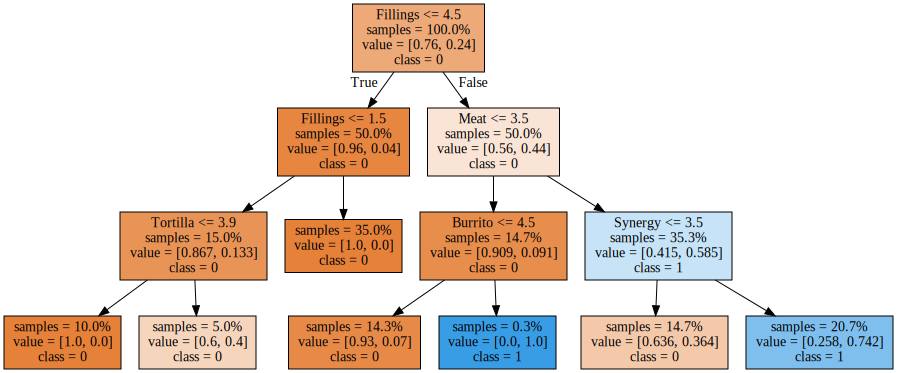

In [169]:
# This score is too good to be true.
# Visualize the decision tree, to see what the model "learned"

import graphviz
from sklearn.tree import export_graphviz

tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree, 
    out_file=None, 
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    impurity=False,
    proportion=True
)

graphviz.Source(dot_data)

Drop the column with “leakage”.

In [174]:
features = train.columns.drop([target, 'Date'])

X_train = train[features]
X_val = val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=3)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7411764705882353


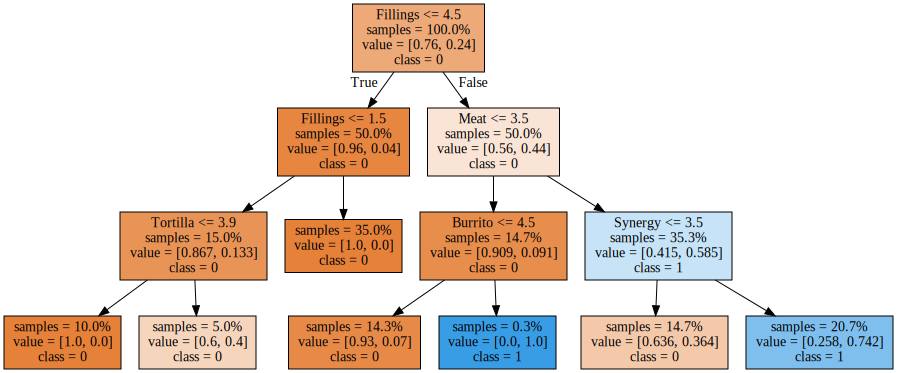

In [172]:

import graphviz
from sklearn.tree import export_graphviz

tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree, 
    out_file=None, 
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    impurity=False,
    proportion=True
)

graphviz.Source(dot_data)

# Choose an appropriate evaluation metric

## Overview

How will you evaluate success for your predictive model? You must choose an appropriate evaluation metric, depending on the context and constraints of your problem.

**Classification & regression metrics are different!**

- Don’t use _regression_ metrics to evaluate _classification_ tasks.
- Don’t use _classification_ metrics to evaluate _regression_ tasks.

[Scikit-learn has lists of popular metrics.](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)

## Follow Along

For classification problems: 

As a rough rule of thumb, if your majority class frequency is >= 50% and < 70% then you can just use accuracy if you want. Outside that range, accuracy could be misleading — so what evaluation metric will you choose, in addition to or instead of accuracy? For example:

- Precision?
- Recall?
- ROC AUC?


### Precision & Recall

Let's review Precision & Recall. What do these metrics mean, in scenarios like these?

- Predict great burritos
- Predict fraudulent transactions
- Recommend Spotify songs

[Are false positives or false negatives more costly? Can you optimize for dollars?](https://alexgude.com/blog/machine-learning-metrics-interview/)

### ROC AUC 

Let's also review ROC AUC (Receiver Operating Characteristic, Area Under the Curve).

[Wikipedia explains,](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) "A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. **The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.**"

ROC AUC is the area under the ROC curve. [It can be interpreted](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it) as "the expectation that a uniformly drawn random positive is ranked before a uniformly drawn random negative." 

ROC AUC measures **how well a classifier ranks predicted probabilities.** So, when you get your classifier’s ROC AUC score, you need to **use predicted probabilities, not discrete predictions.**

ROC AUC ranges **from 0 to 1.** Higher is better. A naive majority class **baseline** will have an ROC AUC score of **0.5**, regardless of class (im)balance.

#### Scikit-Learn docs
- [User Guide: Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc)
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

#### More links
- [StatQuest video](https://youtu.be/4jRBRDbJemM)
- [Data School article / video](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)


In [175]:
from sklearn.metrics import roc_auc_score

y_pred_probab = pipeline.predict_proba(X_val)[:, -1]
roc_auc_score(y_val, y_pred_probab)

0.7536666666666667

In [176]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_probab)

pd.DataFrame({
  'False Positive Rate': fpr,
  'True Positive Rate': tpr,
  'Threshold': thresholds          
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.00,1.741935
1,0.083333,0.32,0.741935
2,0.250000,0.44,0.400000
3,0.316667,0.80,0.363636
4,0.383333,0.88,0.069767
5,1.000000,1.00,0.000000


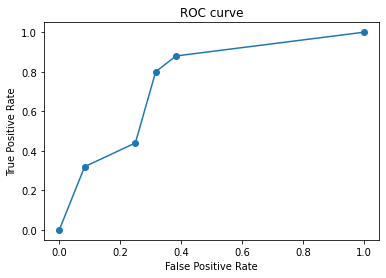

In [177]:
# See the results on a plot.
# This is the "Receiver Operating Characteristic curve"
import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

### Imbalanced classes

Do you have highly imbalanced classes?

If so, you can try ideas from [Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/):

- “Adjust the class weight (misclassification costs)” — most scikit-learn classifiers have a `class_balance` parameter.
- “Adjust the decision threshold” — we did this last module. Read [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415).
- “Oversample the minority class, undersample the majority class, or synthesize new minority classes” — try the the [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library as a stretch goal.

# BONUS: Regression example 🏘️


In [ ]:
# Read our NYC apartment rental listing dataset
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')

### Choose your target

Which column in your tabular dataset will you predict?


In [ ]:
y = df['price']

### How is your target distributed?

For a regression problem, determine: Is the target right-skewed?


In [ ]:
# Yes, the target is right-skewed
import seaborn as sns
sns.distplot(y);

In [ ]:
y.describe()

### Are some observations outliers? 

Will you exclude
them?


In [ ]:
# Yes! There are outliers
# Some prices are so high or low it doesn't really make sense.
# Some locations aren't even in New York City

# Remove the most extreme 1% prices, 
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
import numpy as np
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [ ]:
# The distribution has improved, but is still right-skewed
y = df['price']
sns.distplot(y);

In [ ]:
y.describe()

### Log-Transform

If the target is right-skewed, you may want to “log transform” the target.


> Transforming the target variable (using the mathematical log function) into a tighter, more uniform space makes life easier for any [regression] model.
>
> The only problem is that, while easy to execute, understanding why taking the log of the target variable works and how it affects the training/testing process is intellectually challenging. You can skip this section for now, if you like, but just remember that this technique exists and check back here if needed in the future.
>
> Optimally, the distribution of prices would be a narrow “bell curve” distribution without a tail. This would make predictions based upon average prices more accurate. We need a mathematical operation that transforms the widely-distributed target prices into a new space. The “price in dollars space” has a long right tail because of outliers and we want to squeeze that space into a new space that is normally distributed. More specifically, we need to shrink large values a lot and smaller values a little. That magic operation is called the logarithm or log for short. 
>
> To make actual predictions, we have to take the exp of model predictions to get prices in dollars instead of log dollars. 
>
>— Terence Parr & Jeremy Howard, [The Mechanics of Machine Learning, Chapter 5.5](https://mlbook.explained.ai/prep.html#logtarget)

[Numpy has exponents and logarithms](https://docs.scipy.org/doc/numpy/reference/routines.math.html#exponents-and-logarithms). Your Python code could look like this:

```python
import numpy as np
y_train_log = np.log1p(y_train)
model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
print(mean_absolute_error(y_val, y_pred))
```

In [ ]:
sns.distplot(y)
plt.title('Original target, in the unit of US dollars');

In [ ]:
y_log = np.log1p(y)
sns.distplot(y_log)
plt.title('Log-transformed target, in log-dollars');

In [ ]:
y_untransformed = np.expm1(y_log)
sns.distplot(y_untransformed)
plt.title('Back to the original units');

## Challenge

You will use your portfolio project dataset for all assignments this sprint. (If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.)

Complete these tasks for your project, and document your decisions.

- Choose your target. Which column in your tabular dataset will you predict?
- Is your problem regression or classification?
- How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- Begin to clean and explore your data.
- Begin to choose which features, if any, to exclude. Would some features "leak" future information?

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)